In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

(737, 3)
[[ 0.67524267 -0.28162699  0.6817137 ]
 [ 0.9287122   0.12590211  0.34877258]
 [ 0.64764747 -0.28188593  0.70787928]
 ...
 [ 0.81254403 -0.22259607  0.53872367]
 [ 0.96725598 -0.18789444  0.17062108]
 [ 0.83026857 -0.11339228  0.54570715]]


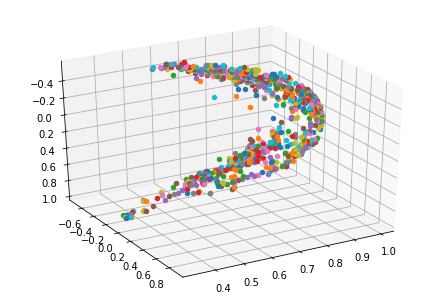

In [19]:
all_texts=[]
os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbcsport")
# os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbc")
directories = os.listdir()
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read()) 
    os.chdir('..')
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
print(vectors_dense_svd.shape)
fig=plt.figure()
ax = Axes3D(fig)
X = vectors_dense_svd
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [20]:
K=5
P=30
cross_over_rate=0.1
mutation_rate=0.01

In [21]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [22]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [23]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [24]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [25]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [26]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [27]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            for j in range(len(parent1)):
                if np.random.randint(0,1)==1:
                    temp_val = parent1[j]
                    parent1[j] = parent2[j]
                    parent2[j] = temp_val
            _,fitness_values = fitness_evaluation([parent1,parent2])
            temp[fitness_values[0]]=parent1
            temp[fitness_values[1]]=parent2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [28]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [29]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

In [30]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [31]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [32]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [33]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [38]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    population = population_initialization()
    gen=0
    return_chromosome=[]
    for i in range(150):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        centers=[]
        purity = davies_bouldin_index(population[fitness.index(max(fitness))])
        print("Generation: "+str(gen)+" | Purity: "+str(purity))
    return population[fitness.index(max(fitness))]

In [39]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['r','m','y','k','c']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 120)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Purity: 1.1873988573545808
Generation: 2 | Purity: 1.0704310202803828
Generation: 3 | Purity: 1.4286447988734159
Generation: 4 | Purity: 0.8346487958764222
Generation: 5 | Purity: 0.7628263424092214
Generation: 6 | Purity: 0.6986487054365
Generation: 7 | Purity: 0.7626020120052264
Generation: 8 | Purity: 0.7537329267343273
Generation: 9 | Purity: 0.7567447247157719
Generation: 10 | Purity: 0.7532515742361071
Generation: 11 | Purity: 0.8129349400859018
Generation: 12 | Purity: 0.7572575715894606
Generation: 13 | Purity: 0.7637571479373998
Generation: 14 | Purity: 0.7663862783245162
Generation: 15 | Purity: 0.7466627292330321
Generation: 16 | Purity: 0.738906927854312
Generation: 17 | Purity: 0.7472741318189066
Generation: 18 | Purity: 0.7025669763493971
Generation: 19 | Purity: 0.6869740293228604
Generation: 20 | Purity: 1.7227678769730657
Generation: 21 | Purity: 0.6827473762978867
Generation: 22 | Purity: 0.6740250055004058
Generation: 23 | Purity: 0.731471746831075
Ge

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 64 | Purity: 0.718692428276735
Generation: 65 | Purity: 0.7161527721591531
Generation: 66 | Purity: 0.7559503636245202
Generation: 67 | Purity: 0.7875803459847217
Generation: 68 | Purity: 0.7582751006897582
Generation: 69 | Purity: 0.7401776737370561
Generation: 70 | Purity: 0.7376959136041992
Generation: 71 | Purity: 0.7097438137423052
Generation: 72 | Purity: 0.6963993413063396
Generation: 73 | Purity: 0.6908165030856435
Generation: 74 | Purity: 0.6876376273883271
Generation: 75 | Purity: 1.144531043602269
Generation: 76 | Purity: 0.6749939198039127
Generation: 77 | Purity: 0.7343768436788587
Generation: 78 | Purity: 0.6887535559847611
Generation: 79 | Purity: 0.6846324395943322
Generation: 80 | Purity: 0.6730234006854722
Generation: 81 | Purity: 0.6769890925754569
Generation: 82 | Purity: 0.6773903654570941
Generation: 83 | Purity: 0.6773903654570941
Generation: 84 | Purity: 0.6773903654570941
Generation: 85 | Purity: 0.6773903654570941
Generation: 86 | Purity: 0.6773903

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 104 | Purity: 0.8033909754535705
Generation: 105 | Purity: 0.9864309784433476
Generation: 106 | Purity: 0.9797014659587341
Generation: 107 | Purity: 0.9012819690106091
Generation: 108 | Purity: 0.7425523537129701
Generation: 109 | Purity: 0.7046189348526738
Generation: 110 | Purity: 0.7238425947641252
Generation: 111 | Purity: 0.6861707647350705
Generation: 112 | Purity: 0.6835552367612263
Generation: 113 | Purity: 0.6841063722410716
Generation: 114 | Purity: 0.6844223315868284
Generation: 115 | Purity: 0.684743220212058
Generation: 116 | Purity: 0.6841137070613481
Generation: 117 | Purity: 0.6841137070613481
Generation: 118 | Purity: 0.6841137070613481
Generation: 119 | Purity: 0.6841137070613481
Generation: 120 | Purity: 0.6841137070613481
Generation: 121 | Purity: 1.4254923420807701
Generation: 122 | Purity: 0.6841137070613481
Generation: 123 | Purity: 0.7733949477264079
Generation: 124 | Purity: 0.7708574196925122
Generation: 125 | Purity: 0.6841137070613481
Generation:

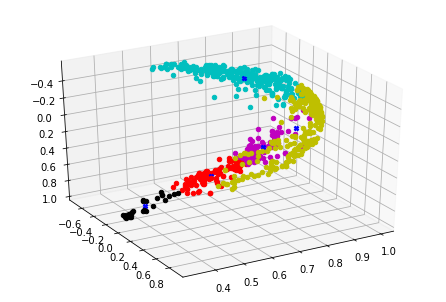

In [40]:
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)